# Machine Learning Algorithms

## Imports

In [793]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import pandas as pd
from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

from sklearn.datasets import load_iris

## General Purpose Methods

### Distance

In [794]:
class Distance:
    @staticmethod
    def squared_euclidean_distance(X,y):
        # Tile the vector y to create a matrix with the same number 
        # of rows as X and the same number of columns as y
        y = np.tile(y, (X.shape[0], 1))
        
        # Calculate the squared Euclidean distance between each row of x and y
        squared_distance = np.square(X - y).sum(axis=1)
        
        return squared_distance

    @staticmethod
    def euclidean_distance(X, y):
        squared_distance = Distance.squared_euclidean_distance(X,y)
        
        # Take the square root to get the Euclidean distance
        distance = np.sqrt(squared_distance)
    
        return distance

### Curves

In [795]:
class Curve:
    @staticmethod
    def EM_alg_cost_evolution_curve(costs):
        total_iterations = len(costs)//2

        # Plot the evolution of the cost function
        for i in range(2*total_iterations-1):
            # Alternate the marker color for costs calculated after an expectation step (even position) 
            # or a maximization step (odd position)
            color = 'darkslateblue' if i % 2 == 0 else 'crimson'
            label='After Expectation Step' if i == 0 else 'After Maximization Step' if i == 1 else ''
            plt.plot([i, i+1], [costs[i], costs[i+1]], marker='o', mfc=color, mec=color, ms='7', ls=':', color='black', label=label)
        last_point = 2*total_iterations-1
        plt.plot(last_point, costs[last_point], marker='o', mfc='crimson', mec='crimson', ms='7')

        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.suptitle('K-means cost evolution', y=1.03)
        plt.title(r'Cost function: $\frac{1}{2}\sum_{i=1}^{N} ||\mathbf{x}_{i} - \mathbf{\hat\mu}_{\hat y_{i}}||^{2}$')
        plt.grid(True)
        plt.legend()

        iterations_ticks = [val for i in range(1, total_iterations + 1) for val in ['', i]]
        plt.xticks(range(2*total_iterations), iterations_ticks)
        
        plt.show()

        # Construct reporting table
        data = []

        for i in range(len(costs)):
            iter = str(i//2)+'a' if i%2==0 else str(i//2)+'b'  # Increasing index for every 2 rows
            step = 'E-step' if i % 2 == 0 else 'M-step'
            cost = costs[i]
            data.append({'Iteration': iter, 'Step': step, 'Cost': cost})

        cost_evolution = pd.concat([pd.DataFrame([d]) for d in data], ignore_index=True).set_index('Iteration')

        return cost_evolution
        

## Fetch Data

### Load Zoo dataset

In [796]:
column_names = ["name", "hair", "feathers", "eggs", "milk", "airbone", "aquatic", "predator", "toothed", "backbone", "breathes", "venomous", "fins", "legs", "tail", "domestic", "catsize", "type"]
column_types = {"name" : str,
                "hair" : int,
                "feathers" : int,
                "eggs" : int,
                "milk" : int,
                "airbone" : int,
                "aquatic" : int,
                "predator" : int,
                "breathes" : int,
                "venomous" : int,
                "fins" : int,
                "legs" : int,
                "tail" : int,
                "domestic" : int,
                "catsize" : int,
                "type" : int
                }

zoo_df = pd.read_csv("../resources/zoo/zoo.data", delimiter=",", header=None, names=column_names, dtype=column_types)
zoo_df.head(-2)

,name,hair,feathers,eggs,milk,airbone,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
5,buffalo,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
6,calf,1,0,0,1,0,0,0,1,1,1,0,0,4,1,1,1,1
7,carp,0,0,1,0,0,1,0,1,1,0,0,1,0,1,1,0,4
8,catfish,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
9,cavy,1,0,0,1,0,0,0,1,1,1,0,0,4,0,1,0,1


### Load Iris dataset

In [797]:
iris_data = load_iris(as_frame=True)
iris_data.frame

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


### Data Preparation

In [798]:
# split initial data into train and test (50 examples for test)
X_train, X_test, y_train, y_test = train_test_split(zoo_df.drop(["name", "type"], axis=1).to_numpy(),
                                                    zoo_df["type"].to_numpy(),
                                                    test_size=20)

# split rest of the train data into train and dev
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, 
                                                  test_size=30)    

In [799]:
# split initial data into train and test (50 examples for test)
X_train, X_test, y_train, y_test = train_test_split(iris_data.data.to_numpy(), 
                                                    iris_data.target.to_numpy(), 
                                                    test_size=50)


# split rest of the train data into train and dev (50 examples for dev)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, 
                                                  test_size=50)

## KNN Classification

### Custom kNN Classifier

In [800]:
from statistics import mode

class kNN:
    def __init__(self, k):
        # k nearest neighbours hyperparameter
        self.k = k

        # X_train: n*m matrix (n examples, m features)
        # X[i] = [xi1, xi2, ..., xim] for i=1 to n
        self.X_train = None
        
        # y_train: n*1 vector (class of each example)
        # y[i] = class of X[i]  for i=1 to n
        self.y_train = None
    
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        Ntest = X_test.shape[0]
        predicted_classes = list()

        for test_example_idx in range(Ntest):
            # Calculate the distance for all train examples
            d = Distance.euclidean_distance(self.X_train, X_test[test_example_idx,:])

            # Return the indices of the K closest instances
            k_closest = np.argsort(d)[:self.k]

            # Find the classes of the k closest instances
            y = self.y_train[k_closest]

            # mode: returns the most frequent (majority vote)
            predicted_classes.append(mode(y))

        return np.array(predicted_classes)

In [801]:
def find_best_k(X_train, y_train, X_dev, y_dev):
  best_k = 0
  best_dev_accuracy = .0
  best_classifier = None 

  for k in tqdm(range(1, 11)):
    knn = kNN(k)  # knn object with current k
    knn.fit(X_train, y_train) # fit with current k in the training data

    predictions = knn.predict(X_dev) # predict with current k using the development data
    accuracy = accuracy_score(y_dev, predictions) # count accuracy

    if accuracy > best_dev_accuracy: 
      best_dev_accuracy = accuracy
      best_k = k
      best_classifier = knn
    
    print('Accuracy for k={0}: {1}'.format(k, accuracy))


  print('\nBest dev accuracy:', best_dev_accuracy)
  print('Best k:', best_k)

  # predict the test data using the best classifier
  test_preds = best_classifier.predict(X_test)
  print('Test accuracy:', accuracy_score(y_test, test_preds))
  print()

  return best_k

### Training & Testing

#### Custom kNN Classifier

In [802]:
best_k = find_best_k(X_train, y_train, X_dev, y_dev)

# Training kNN Classifier
knn_custom = kNN(best_k) 
knn_custom.fit(X_train, y_train)

# Using kNN Classifier
y_custom = knn_custom.predict(X_test)
print(classification_report(y_test, y_custom))

100%|██████████| 10/10 [00:00<00:00, 453.89it/s]

Accuracy for k=1: 0.9
Accuracy for k=2: 0.9
Accuracy for k=3: 0.94
Accuracy for k=4: 0.94
Accuracy for k=5: 0.96
Accuracy for k=6: 0.92
Accuracy for k=7: 0.96
Accuracy for k=8: 0.94
Accuracy for k=9: 0.92
Accuracy for k=10: 0.9

Best dev accuracy: 0.96
Best k: 5
Test accuracy: 0.96

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.88      1.00      0.93        14
           2       1.00      0.88      0.93        16

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



#### Scikit-Learn kNN Classifier

In [803]:
# Training kNN Classifier
knn_scikit = KNeighborsClassifier(n_neighbors=best_k) 
knn_scikit.fit(X_train, y_train)

# Using kNN Classifier
y_scikit = knn_scikit.predict(X_test)
print(classification_report(y_test, y_scikit))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.88      1.00      0.93        14
           2       1.00      0.88      0.93        16

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



## K-means Clustering

### Custom k-means

In [804]:
class kMeans:
    def __init__(self, k, max_iters):
        # k = number of clusters
        self.k = k
        # define the maximum number of iterations
        self.max_iters = max_iters
        # the centroids for all labels
        self.centroids = None

    @staticmethod
    def cost_function(X, c, labels): 
        return 0.5*sum(Distance.squared_euclidean_distance(X[i].reshape((1,X[i].shape[0])), c[labels[i]]) for i in range(X.shape[0]))
    
    def fit(self, X):
        # Choose k random points of data as centroids
        indices = np.random.choice(X.shape[0], self.k, replace=False)
        self.centroids = X[indices]

        costs = list()

        for iter in range(self.max_iters):
            # Expectation step
            labels = self.predict(X)  # Assign each data point to the nearest centroid
            costs.append(self.cost_function(X, self.centroids, labels).item()) # Calculate the cost 

            # Maximization step
            new_centroids = np.array([np.mean(X[labels == label], axis=0) for label in range(self.k)])
            costs.append(self.cost_function(X, new_centroids, labels).item()) # Calculate the new cost
            
            # If the algorithm has converged, then stop
            if np.all(self.centroids == new_centroids):
                break
                
            self.centroids = new_centroids

        iters = len(costs)//2
        return costs, iters

    def predict(self, X):
        # Assign each data point to the nearest centroid 
        distances = np.array([Distance.squared_euclidean_distance(self.centroids, x) for x in X])
        labels = np.argmin(distances, axis=1)

        return labels


### Training & Testing

💡We will use the KMeans algorithm to cluster the observations of the training set (X_train), as clustering is commonly performed for grouping existing observations rather than predicting the cluster to which a new observation would belong. 

❗For evaluating the algorithm's performance, it is crucial to note that the cluster labels assigned by KMeans may not necessarily align with the true class labels. Therefore, other evaluation metrics should be employed that take into account whether observations that normally belong to the same class are indeed found in the same cluster.

✔️We are going to use 3 commonly used clustering performance evaluation metrics (given that the ground truth is known):
1. <b>Adjusted Rand Index</b>: It is a function that measures the similarity of the two assignments, ignoring permutations:
    - $ARI = (RI - Expected_{RI}) / (max(RI) - Expected_{RI})$ <br> where $RI$ = (number of agreeing pairs) / (number of pairs)
    - The score range is [-1, 1]. Lower values indicate different labelings, similar clusterings have a high index and 1 is the perfect match score.

<br>
    
2. <b>Adjusted Mutual Information</b>: It is a function that measures the agreement of the two assignments, ignoring permutations. Two different normalized versions of this measure are available, Normalized Mutual Information (NMI) and Adjusted Mutual Information (AMI). NMI is often used in the literature, while AMI was proposed more recently and is normalized against chance. We will use AMI.
    - Values close to 0 indicate two label assignments that are largely independent, while values close to 1 indicate significant agreement. Further, an AMI of exactly 1 indicates that the two label assignments are equal (with or without permutation).

<br>

3. <b>Fowlkes-Mallows Index</b>: It is defined as the geometric mean of the pairwise precision and recall:
    - $FMI = \frac{TP}{\sqrt{(TP+FP)(TP+FN)}}$
    - The score ranges from 0 to 1. A high value indicates a good similarity between two clusters.

[Clustering performance evaluation](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

#### Custom k-means

In [805]:
num_of_classes = 3 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
max_iters = 100

# Training k-means
k_means_custom = kMeans(num_of_classes, max_iters) 
costs, iters = k_means_custom.fit(X_train)

# Using k-means
y_custom = k_means_custom.predict(X_train)

# Evaluation of clustering performance using appropriate metrics
ari = metrics.adjusted_rand_score(y_train, y_custom)
ami = metrics.adjusted_mutual_info_score(y_train, y_custom)
fm = metrics.fowlkes_mallows_score(y_train, y_custom)

print("Adjusted Rand Index (ARI): ", ari)
print("Adjusted Mutual Information (AMI): ", ami)
print("Fowlkes-Mallows Index (FM): ", fm)

Adjusted Rand Index (ARI):  0.5143779563030257
Adjusted Mutual Information (AMI):  0.6135219708354837
Fowlkes-Mallows Index (FM):  0.6757756323766119


In [806]:
# Results
print("Iterations run: ", iters)
print("Final Cost: ", costs[-1])
print("Centroids: \n", k_means_custom.centroids)

Iterations run:  4
Final Cost:  14.780500000000004
Centroids: 
 [[5.15333333 3.57333333 1.43333333 0.29333333]
 [5.58       2.72       4.19333333 1.32666667]
 [6.615      3.04       5.23       1.845     ]]


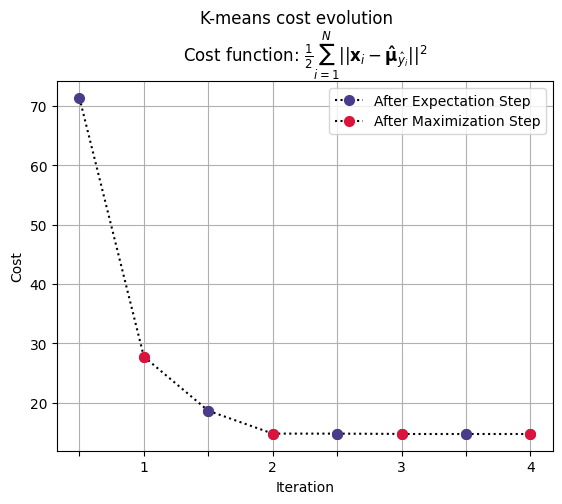

,Step,Cost
Iteration,,
0a,E-step,71.310
0b,M-step,27.775
1a,E-step,18.683
1b,M-step,14.833
2a,E-step,14.828
2b,M-step,14.781
3a,E-step,14.781
3b,M-step,14.781


In [807]:
# The evolution of the cost function
report_cost_evolution = Curve.EM_alg_cost_evolution_curve(costs)
display(report_cost_evolution)

#### Scikit-learn k-means

In [808]:
# Training k-means
k_means_scikit = KMeans(n_clusters=num_of_classes)
k_means_scikit.fit(X_train)

# Using k-means
y_scikit = k_means_scikit.predict(X_train)

# Evaluate clustering performance using appropriate metrics
ari = metrics.adjusted_rand_score(y_train, y_scikit)
ami = metrics.adjusted_mutual_info_score(y_train, y_scikit)
fm = metrics.fowlkes_mallows_score(y_train, y_scikit)

print("Adjusted Rand Index (ARI): ", ari)
print("Adjusted Mutual Information (AMI): ", ami)
print("Fowlkes-Mallows Index (FM): ", fm)


Adjusted Rand Index (ARI):  0.6407474129624199
Adjusted Mutual Information (AMI):  0.6670661658883699
Fowlkes-Mallows Index (FM):  0.7610118277186023


c:\Users\alvio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [817]:
# Results
print("Iterations run: ", k_means_scikit.n_iter_)
print("Final Cost: ", 1/2 * k_means_scikit.inertia_)    # inertia does not include an 1/2 factor as we did in our implementation, so we need to multiply it to be able to compare the 2 costs
print("Centroids: \n", k_means_scikit.cluster_centers_)

Iterations run:  4
Final Cost:  14.75752380952381
Centroids: 
 [[6.8        3.02857143 5.42857143 1.94285714]
 [5.15333333 3.57333333 1.43333333 0.29333333]
 [5.75238095 2.81904762 4.35714286 1.40952381]]


## Principal Component Analysis

### With SVD & Classic PCA

In [810]:
class PCA:
    def __init__(self, m):
        self.m = m

    def svd_reduction(self, X):
        U, S, V = np.linalg.svd(X, full_matrices=False)
        print( "U", U.shape, "S", S.shape, "V", V.shape )
        mu = X.mean(axis=0)

        eigvecs = V[:self.m,:]
        eigvals = S[:self.m]
        print( 'X', X.shape, 'eigvecs', eigvecs.shape, 'eigvals', eigvals.shape )
        Z = (X-mu).dot(eigvecs.T)
        print( 'Z', Z.shape )
        return Z, eigvecs, eigvals, mu
    
    def classic_reduction(self, X):
        mu = X.mean(axis=0).reshape( (1,-1) )

        normalized_X = X-mu

        S = (1/X.shape[0]) * normalized_X.T.dot( normalized_X )

        eigvectors, eigvals = self.eigsort( S )

        U = eigvectors[:,:self.m]
        Lambdas = eigvals[:self.m]
        print( X.shape, U.shape, Lambdas.shape )

        Z = normalized_X.dot(U)
        return Z, U, Lambdas, mu
    
    def eigsort(self, A):
        eigvals, U = np.linalg.eig(A)
        # sort eigenvalues in descending order
        order = np.argsort(eigvals)[::-1]
        eigvals = eigvals[order]
        #re-arrange the eigenvectors
        U = U[:,order]
        return U, eigvals

In [811]:
m = 3

iris_data = load_iris(as_frame=True)
iris_data.frame

# split initial data into train and test (50 examples for test)
X_train, X_test, y_train, y_test = train_test_split(iris_data.data.to_numpy(), 
                                                    iris_data.target.to_numpy(), 
                                                    test_size=50)


# split rest of the train data into train and dev (50 examples for dev)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, 
                                                  test_size=50)

pca = PCA(m)
z, eva, eve, mu = pca.svd_reduction(X_train)
print(z.shape)

U (50, 4) S (4,) V (4, 4)
X (50, 4) eigvecs (3, 4) eigvals (3,)
Z (50, 3)
(50, 3)


In [812]:
z, u, eva, mu = pca.classic_reduction(X_train)
print(z.shape)

(50, 4) (4, 3) (3,)
(50, 3)


## Least Squares Classification

Consider a classification problem with  classes, with a 1-of-K binary coding scheme for the target vector t. Each class $C_k$ has its own linear model.

Each class $C_k$ is described by its own linear model so that: $y_k(\mathbf{x})=\mathbf{w}_k^T \mathbf{x} + w_{k0}$ where k=1,...,K, or, using vector notation: $$\mathbf{ y(x) = {\tilde W}^T \tilde x }$$

where $\mathbf{\tilde W}$ is a matrix whose $k^{th}$ column comprises the $D+1$-dimensional vector $ \mathbf {\tilde w}_k = (w_{k0} ; \mathbf{w}_k^T)^T$ and $ \mathbf {\tilde x}$ is the corresponding augmented input vector $(1;\mathbf{x}^T)^T$ with a dummy input $x_0 = 1$. Assign new input $\mathbf x$ to the class $C_k$ if $k=argmax\;y_j (\mathbf x)$. Consider a training data set $\{\mathbf {x}_n, \mathbf {t}_n \}$ where $n=1,...,N$ and define a matrix $\mathbf T$ whose $n^{th}$ row is the vector $\mathbf{t}_n^T$.

The sum-of-squares error function can then be written as:
$E_D(\mathbf{\tilde W}) = \frac{1}{2}Tr((\mathbf{\tilde{X} \tilde{W} - T})^T(\mathbf{\tilde{X} \tilde{W} - T}))$.

➡️  Setting the derrivative wrt $\tilde W$ to zero, and rearranging, we obtain the solution:
$\mathbf {\tilde{W} = (\tilde{X}^T\tilde{X})^{-1}\tilde{X}^TT}$, where $(\tilde{X}^T\tilde{X})^{-1}\tilde{X}^T$ is the pseudo-inverse of $\mathbf{\tilde X}.$

➡️  We then obtain the discriminant function in the form $\mathbf{ y(x) = {\tilde W}^T \tilde x }$ 

<i>Bishop, C. M. (2006). Pattern Recognition and Machine Learning (Chapter 4.1.3: Least Squares for Classification). Springer.</i>


### Custom Least Squares Classifier

In [823]:
class LeastSquares:

    def __init__(self):
        self.W = None

    def fit(self, X_train, y_train):
        # Insert 1 as the first column in X to augment the input vectors with a dummy input x_0 = 1
        X = np.insert(X_train, 0, 1, axis=1)
        # T: T[i] = one-hot vector for the class of example i
        T = pd.get_dummies(y_train).astype(int)
        # W: W = pseudo_inverse(X) * T
        self.W = np.linalg.pinv(X).dot(T)

    def predict(self, X_test):
        # Insert 1 as the first column in X to augment the input vectors with a dummy input x_0 = 1
        X = np.insert(X_test, 0, 1, axis=1)
        # Y: Y = transpose(W) * transpose(X)
        Y = self.W.T.dot(X.T)

        classes = np.argmax(Y, axis=0)
        return classes

### Training & Testing

#### Custom Least Squares Classifier

In [825]:
# Training LeastSquares
least_squares = LeastSquares()
least_squares.fit(X_train, y_train)

# Using LeastSquares
y_custom = least_squares.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.67      0.71      0.69        17
           2       0.64      0.60      0.62        15

    accuracy                           0.78        50
   macro avg       0.77      0.77      0.77        50
weighted avg       0.78      0.78      0.78        50



#### Scikit-Learn Least Squares Classifier